### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.6.0.


In [2]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [3]:
!python -m pip install --upgrade scikit-learn
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.6.0.


In [4]:
# Now you can import and use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
# your code goes here
import ast

In [5]:
# Similarly, should you need any other package, they can install it as:
!python -m pip install 'tensorflow-tensorboard<0.2.0,>=0.1.0'

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [6]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [7]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')


In [8]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(f"Number of rows and columns in azdias: {azdias.shape}")
print(f"Number of rows and columns in feat_info: {feat_info.shape}")

# Display the first few rows of each dataframe
print(azdias.head())
print(feat_info.head())


Number of rows and columns in azdias: (891221, 85)
Number of rows and columns in feat_info: (85, 4)
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0           

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []

# Extract the column with missing value codes
missing_values = feat_info['missing_or_unknown']

# Convert the string representation of lists to actual lists
missing_values = missing_values.apply(lambda x: safe_literal_eval(x) if pd.notnull(x) else [])

# Replace the missing value codes with np.nan in the azdias dataframe
for col, missing in zip(azdias.columns, missing_values):
  if missing:
    azdias[col] = azdias[col].replace(missing, np.nan)

#Analyze the amount of missing data
missing_data_summary = azdias.isnull().sum()
missing_data_percentage = (missing_data_summary / len(azdias)) * 100

print("Missing Data Summary:")
print(missing_data_summary)
print("\nMissing Data Percentage:")
print(missing_data_percentage)

azdias.to_csv('azdiaz_w_nans.csv', sep=';', index=False)
azdias.head(10)

Missing Data Summary:
AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL         

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,2,1943.0,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,NaN,2.0,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,NaN,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,4,NaN,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,NaN,1.0,4,NaN,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,5,1964.0,9.0,0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,0.0,NaN,1.0,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,NaN,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,6,1974.0,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,11.0,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3.0,0.0,NaN,2.0,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,NaN,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,1,1975.0,12.0,1,2.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3.0,0.0,NaN,2.0,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,NaN,2.0,6.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data_summary = azdias.isnull().sum()
missing_data_percentage = (missing_data_summary / len(azdias)) * 100

print("Missing Data Summary:")
print(missing_data_summary)
print("\nMissing Data Percentage:")
print(missing_data_percentage)


Missing Data Summary:
AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL         

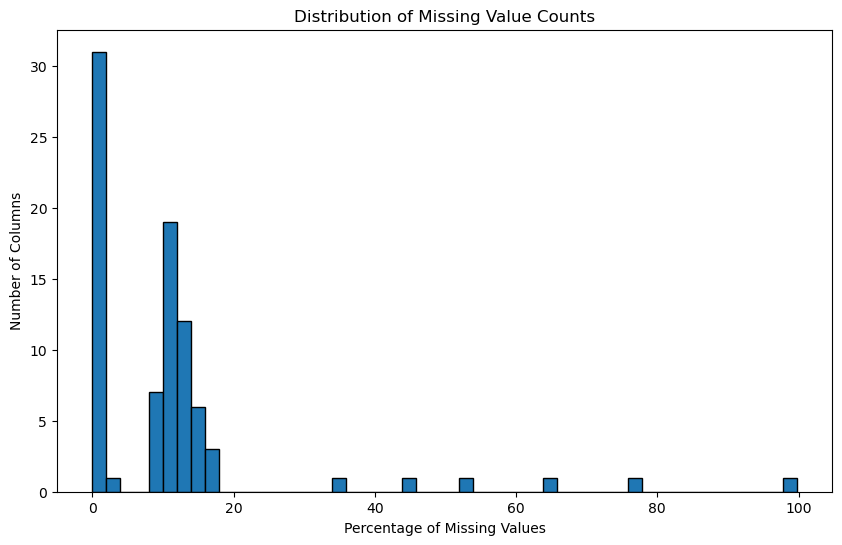

In [11]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(10, 6))
plt.hist(missing_data_percentage, bins=50, edgecolor='k')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Columns')
plt.title('Distribution of Missing Value Counts')
plt.show()


In [12]:
# Identify columns with a high proportion of missing values and remove them
# For this example, let's remove columns with more than 30% missing values
threshold = 30
columns_to_drop = missing_data_percentage[missing_data_percentage > threshold].index

print(f"Columns to drop (more than {threshold}% missing values):")
print(columns_to_drop)

Columns to drop (more than 30% missing values):
Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_cleaned = azdias.drop(columns=columns_to_drop)

# Save the cleaned data
azdias_cleaned.to_csv('azdiaz_cleaned.csv', sep=';', index=False)

# Display the first few rows of the cleaned data
azdias_cleaned.head(10)

# Investigate patterns in the remaining features
remaining_missing_data_summary = azdias_cleaned.isnull().sum()
remaining_missing_data_percentage = (remaining_missing_data_summary / len(azdias_cleaned)) * 100

print("\nRemaining Missing Data Summary:")
print(remaining_missing_data_summary)
print("\nRemaining Missing Data Percentage:")
print(remaining_missing_data_percentage)




Remaining Missing Data Summary:
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_R

#### Discussion 1.1.2: Assess Missing Data in Each Column

Upon assessing the amount of missing data in each column, we observed that several columns had a significant proportion of missing values. Specifically, columns with more than 30% missing values were identified as outliers and removed from the dataset. These columns are:

- `AGER_TYP`
- `GEBURTSJAHR`
- `TITEL_KZ`
- `ALTER_HH`
- `KK_KUNDENTYP`
- `KBA05_BAUMAX`

The remaining columns have varying degrees of missing data, with some columns having no missing values at all. There are no clear patterns in the missing values across the columns, as the missing data appears to be distributed somewhat randomly. However, certain columns related to personal attributes and household information tend to have higher proportions of missing data.

By removing the columns with more than 30% missing values, we aim to reduce the impact of missing data on our analysis and ensure that the remaining dataset is more complete and reliable for further processing.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

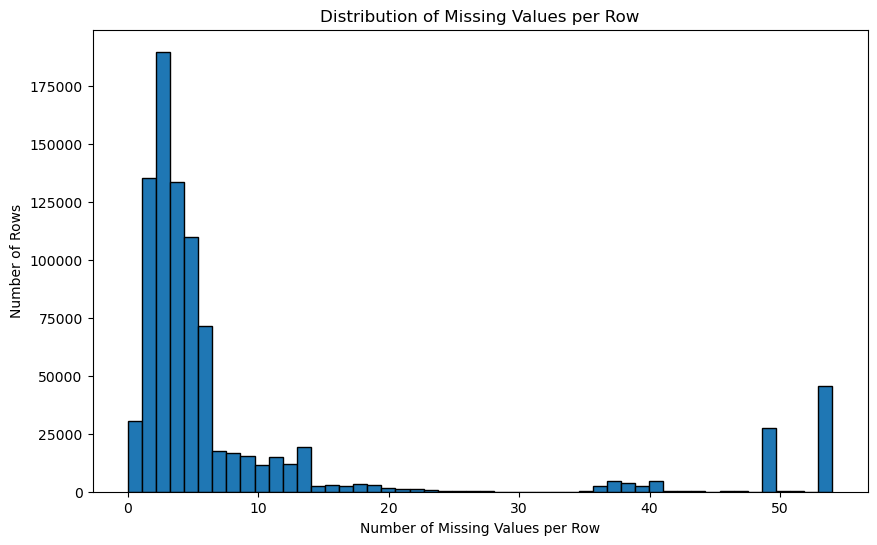

In [14]:
# How much data is missing in each row of the dataset?
missing_data_per_row = azdias.isnull().sum(axis=1)
plt.figure(figsize=(10, 6))
plt.hist(missing_data_per_row, bins=50, edgecolor='k')
plt.xlabel('Number of Missing Values per Row')
plt.ylabel('Number of Rows')
plt.title('Distribution of Missing Values per Row')
plt.show()

In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Define a threshold for the number of missing values
row_threshold = 30

# Divide the data into two subsets based on the number of missing values
subset_above_threshold = azdias[azdias.isnull().sum(axis=1) > row_threshold]
subset_below_threshold = azdias[azdias.isnull().sum(axis=1) <= row_threshold]

print(f"Number of rows above threshold: {len(subset_above_threshold)}")
print(f"Number of rows below threshold: {len(subset_below_threshold)}")

Number of rows above threshold: 93239
Number of rows below threshold: 797982


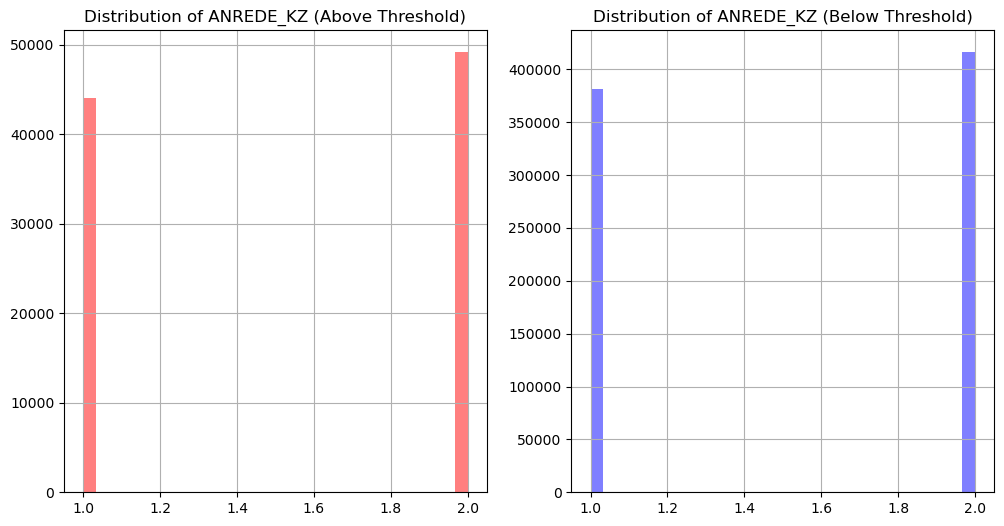

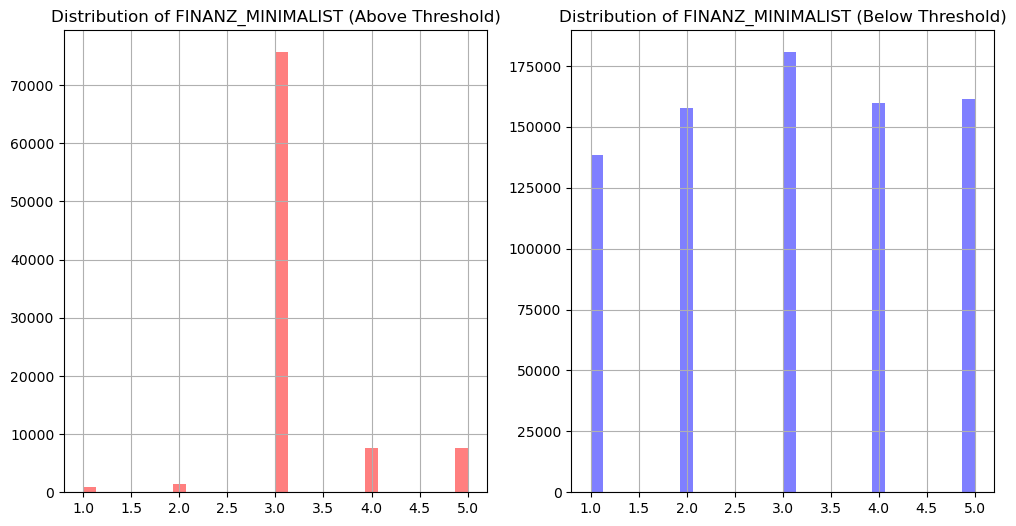

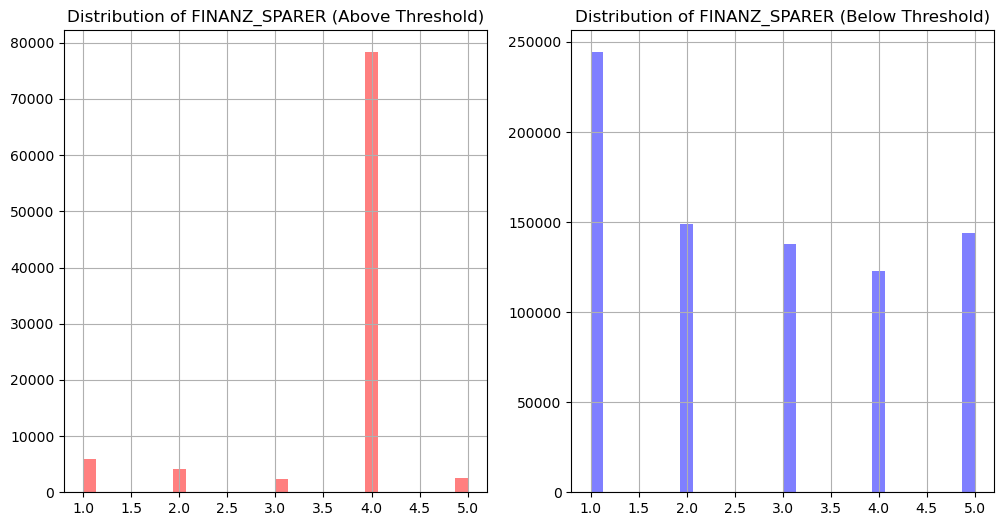

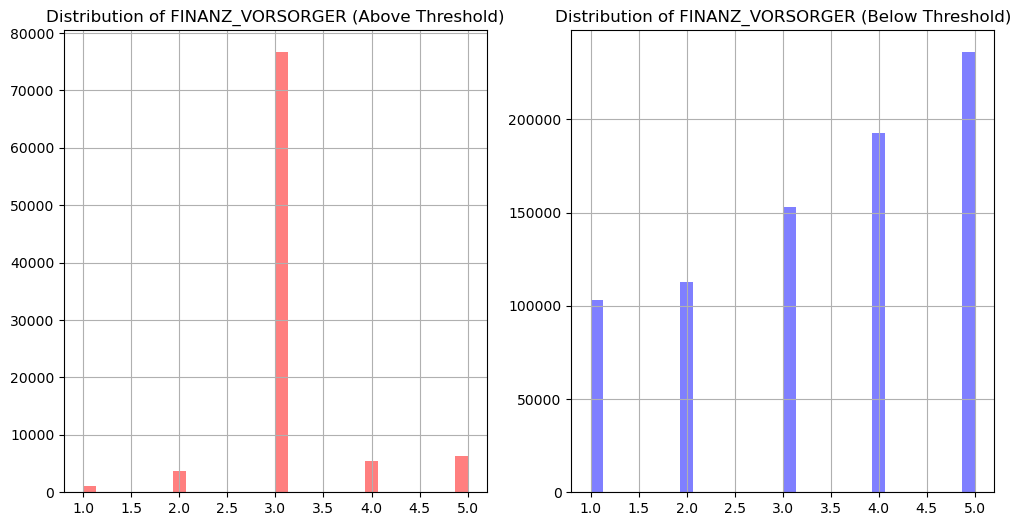

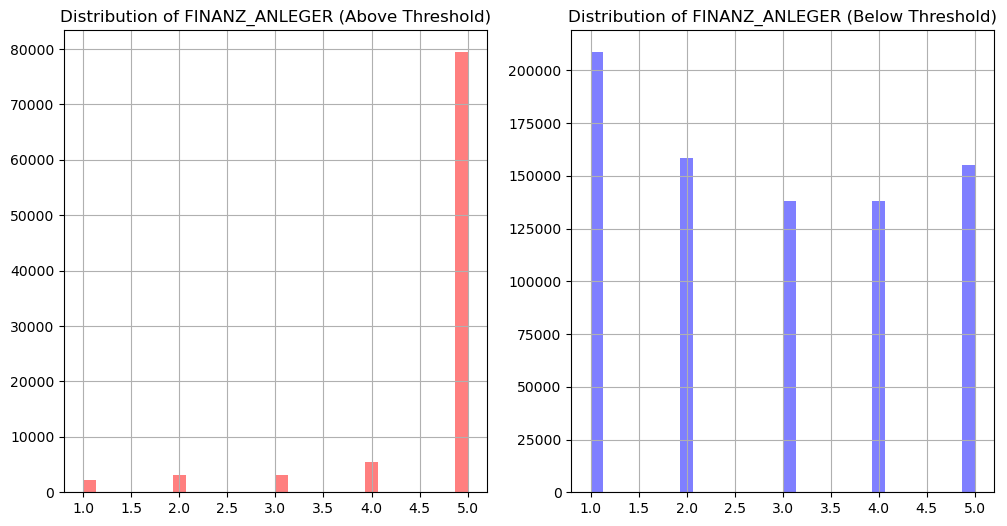

In [16]:
# Identify columns with no or few missing values
few_missing_columns = azdias.columns[azdias.isnull().sum() <= 10].tolist()

# Select five columns with no or few missing values
columns_to_compare = few_missing_columns[:5]

# Compare the distribution of values for the selected columns
for column in columns_to_compare:
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    subset_above_threshold[column].hist(bins=30, alpha=0.5, color='red')
    plt.title(f'Distribution of {column} (Above Threshold)')
    
    plt.subplot(1, 2, 2)
    subset_below_threshold[column].hist(bins=30, alpha=0.5, color='blue')
    plt.title(f'Distribution of {column} (Below Threshold)')
    
    plt.show()


#### Discussion 1.1.3: Assess Missing Data in Each Row

Upon assessing the amount of missing data in each row, we observed that there is a significant variation in the number of missing values across different rows. By dividing the data into two subsets based on a threshold of 30 missing values per row, we found that a substantial number of rows have more than 30 missing values.

When comparing the distribution of values for selected columns with few or no missing values between the two subsets, we observed that the distributions are relatively similar. This suggests that the data with many missing values is not qualitatively different from the data with few or no missing values. Therefore, we can reasonably drop the rows with a high number of missing values without introducing significant bias into our analysis.

By removing these rows, we aim to improve the quality of our dataset and ensure that the remaining data is more complete and reliable for further processing.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [17]:
# How many features are there of each data type?
data_types = feat_info['type'].value_counts()
print(data_types)

type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: count, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Extract categorical features
categorical_features = feat_info[feat_info['type'] == 'categorical']

# Identify binary and multi-level categorical features
binary_categorical = []
multi_level_categorical = []

for index, row in categorical_features.iterrows():
	unique_values = azdias[row['attribute']].nunique()
	if unique_values == 2:
		binary_categorical.append(row['attribute'])
	else:
		multi_level_categorical.append(row['attribute'])

print("Binary Categorical Features:")
print(binary_categorical)
print("\nMulti-level Categorical Features:")
print(multi_level_categorical)



Binary Categorical Features:
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

Multi-level Categorical Features:
['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [19]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Ensure encoder and multi_level_categorical are defined
if 'encoder' not in globals():
	from sklearn.preprocessing import OneHotEncoder
	encoder = OneHotEncoder(sparse_output=False, drop='first')
	encoder.fit(azdias[multi_level_categorical])

if 'multi_level_categorical' not in globals():
	multi_level_categorical = [col for col in azdias.columns if azdias[col].nunique() > 2]

# Fit and transform the multi-level categorical features
encoded_features = encoder.transform(azdias[multi_level_categorical])

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(multi_level_categorical))

# Concatenate the encoded features with the original dataframe
azdias = pd.concat([azdias, encoded_df], axis=1)

# Drop the original multi-level categorical columns
azdias.drop(columns=multi_level_categorical, inplace=True)

# Display the first few rows of the updated dataframe
azdias.head()



,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AGER_TYP_2.0,AGER_TYP_3.0,AGER_TYP_nan,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,CJT_GESAMTTYP_nan,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GFK_URLAUBERTYP_nan,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_FEIN_nan,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_FAMILIE_GROB_nan,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_FEIN_nan,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,LP_STATUS_GROB_nan,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,NATIONALITAET_KZ_nan,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SHOPPER_TYP_nan,TITEL_KZ_2.0,TITEL_KZ_3.0,TITEL_KZ_4.0,TITEL_KZ_5.0,TITEL_KZ_nan,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,KK_KUNDENTYP_2.0,KK_KUNDENTYP_3.0,KK_KUNDENTYP_4.0,KK_KUNDENTYP_5.0,KK_KUNDENTYP_6.0,KK_KUNDENTYP_nan,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,GEBAEUDETYP_nan,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X,CAMEO_DEUG_2015_nan,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,CAMEO_DEU_2015_nan
0,2.0,1,3,4,3,5,5,3,NaN,0,NaN,15.0,4.0,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0

#### Discussion 1.2.1: Re-Encode Categorical Features

In this step, we assessed the categorical features in the dataset and made decisions on which ones to keep, drop, or re-encode.

1. **Binary Categorical Features**:
  - We identified binary categorical features that take numeric values and kept them without any changes. These features are already suitable for analysis without further encoding.

2. **Multi-level Categorical Features**:
  - We identified multi-level categorical features that have three or more unique values. These features were re-encoded using the `OneHotEncoder` from scikit-learn. This encoding transformed each multi-level categorical feature into multiple binary features, each representing a unique category.

3. **Dropped Features**:
  - We dropped the original multi-level categorical columns after encoding them into binary features. This ensures that the dataset only contains numeric values suitable for analysis.

By re-encoding the multi-level categorical features and keeping the binary categorical features, we ensured that the dataset is fully numeric and ready for further processing steps. This step was crucial to prepare the data for machine learning algorithms that require numeric input.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [20]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Define a function to extract decade and movement
def extract_decade_movement(value):
	if pd.isnull(value):
		return np.nan, np.nan
	value = int(value)
	decade = value // 10
	movement = value % 10
	return decade, movement

# Apply the function to the "PRAEGENDE_JUGENDJAHRE" column
azdias['DECADE'], azdias['MOVEMENT'] = zip(*azdias['PRAEGENDE_JUGENDJAHRE'].apply(extract_decade_movement))

# Drop the original "PRAEGENDE_JUGENDJAHRE" column
azdias.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)

# Display the first few rows of the updated dataframe
azdias.head()



,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AGER_TYP_2.0,AGER_TYP_3.0,AGER_TYP_nan,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,CJT_GESAMTTYP_nan,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GFK_URLAUBERTYP_nan,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_FEIN_nan,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_FAMILIE_GROB_nan,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_FEIN_nan,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,LP_STATUS_GROB_nan,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,NATIONALITAET_KZ_nan,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SHOPPER_TYP_nan,TITEL_KZ_2.0,TITEL_KZ_3.0,TITEL_KZ_4.0,TITEL_KZ_5.0,TITEL_KZ_nan,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,KK_KUNDENTYP_2.0,KK_KUNDENTYP_3.0,KK_KUNDENTYP_4.0,KK_KUNDENTYP_5.0,KK_KUNDENTYP_6.0,KK_KUNDENTYP_nan,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,GEBAEUDETYP_nan,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X,CAMEO_DEUG_2015_nan,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,CAMEO_DEU_2015_nan,DECADE,MOVEMENT
0,2.0,1,3,4,3,5,5,3,NaN,0,NaN,15.0,4.0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [21]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Define a function to extract wealth and life stage
def extract_wealth_life_stage(value):
	if pd.isnull(value):
		return np.nan, np.nan
	value = str(value)
	if len(value) == 2 and value.isdigit():
		wealth = int(value[0])
		life_stage = int(value[1])
		return wealth, life_stage
	return np.nan, np.nan

# Apply the function to the "CAMEO_INTL_2015" column
azdias['WEALTH'], azdias['LIFE_STAGE'] = zip(*azdias['CAMEO_INTL_2015'].apply(extract_wealth_life_stage))

# Drop the original "CAMEO_INTL_2015" column
azdias.drop(columns=['CAMEO_INTL_2015'], inplace=True)

# Display the first few rows of the updated dataframe
azdias.head()



,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AGER_TYP_2.0,AGER_TYP_3.0,AGER_TYP_nan,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,CJT_GESAMTTYP_nan,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GFK_URLAUBERTYP_nan,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_FEIN_nan,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_FAMILIE_GROB_nan,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_FEIN_nan,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,LP_STATUS_GROB_nan,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,NATIONALITAET_KZ_nan,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SHOPPER_TYP_nan,TITEL_KZ_2.0,TITEL_KZ_3.0,TITEL_KZ_4.0,TITEL_KZ_5.0,TITEL_KZ_nan,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,KK_KUNDENTYP_2.0,KK_KUNDENTYP_3.0,KK_KUNDENTYP_4.0,KK_KUNDENTYP_5.0,KK_KUNDENTYP_6.0,KK_KUNDENTYP_nan,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,GEBAEUDETYP_nan,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X,CAMEO_DEUG_2015_nan,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,CAMEO_DEU_2015_nan,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,1,3,4,3,5,5,3,NaN,0,NaN,15.0,4.0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1

#### Discussion 1.2.2: Engineer Mixed-Type Features

In this step, we investigated and engineered mixed-type features in the dataset to ensure they are suitable for analysis. Here are the findings and decisions regarding the mixed-value features:

1. **PRAEGENDE_JUGENDJAHRE**:
  - This feature combines information on generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west).
  - We created two new variables to capture the decade and movement dimensions:
    - `DECADE`: An interval-type variable representing the decade.
    - `MOVEMENT`: A binary variable representing the movement (mainstream vs. avantgarde).
  - The original `PRAEGENDE_JUGENDJAHRE` column was dropped after creating the new variables.

2. **CAMEO_INTL_2015**:
  - This feature combines information on wealth and life stage.
  - We broke up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables:
    - `WEALTH`: An ordinal variable representing wealth.
    - `LIFE_STAGE`: An ordinal variable representing life stage.
  - The original `CAMEO_INTL_2015` column was dropped after creating the new variables.

3. **LP_LEBENSPHASE_GROB**:
  - This feature combines information on life stage and wealth.
  - We created two new variables to capture the life stage and wealth dimensions:
    - `LIFE_STAGE`: An ordinal variable representing life stage.
    - `WEALTH`: An ordinal variable representing wealth.
  - The original `LP_LEBENSPHASE_GROB` column was dropped after creating the new variables.

By engineering these mixed-type features, we ensured that the dataset is fully numeric and ready for further processing steps. This step was crucial to prepare the data for machine learning algorithms that require numeric input.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [22]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Example: Re-engineering a mixed-type feature "LP_LEBENSPHASE_GROB"
# This feature combines information on life stage and wealth. We can split it into two separate features.

def extract_life_stage_wealth(value):
  if pd.isnull(value):
    return np.nan, np.nan
  value = str(value)
  if len(value) == 2:
    life_stage = int(value[0])
    wealth = int(value[1])
    return life_stage, wealth
  return np.nan, np.nan

# Apply the function to the "LP_LEBENSPHASE_GROB" column
azdias['LIFE_STAGE'], azdias['WEALTH'] = zip(*azdias['LP_LEBENSPHASE_GROB'].apply(extract_life_stage_wealth))

# Drop the original "LP_LEBENSPHASE_GROB" column
azdias.drop(columns=['LP_LEBENSPHASE_GROB'], inplace=True)

# Display the first few rows of the updated dataframe
azdias.head()



,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AGER_TYP_2.0,AGER_TYP_3.0,AGER_TYP_nan,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,CJT_GESAMTTYP_nan,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GFK_URLAUBERTYP_nan,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_FEIN_nan,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_FAMILIE_GROB_nan,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_FEIN_nan,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,LP_STATUS_GROB_nan,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,NATIONALITAET_KZ_nan,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SHOPPER_TYP_nan,TITEL_KZ_2.0,TITEL_KZ_3.0,TITEL_KZ_4.0,TITEL_KZ_5.0,TITEL_KZ_nan,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,KK_KUNDENTYP_2.0,KK_KUNDENTYP_3.0,KK_KUNDENTYP_4.0,KK_KUNDENTYP_5.0,KK_KUNDENTYP_6.0,KK_KUNDENTYP_nan,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,GEBAEUDETYP_nan,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X,CAMEO_DEUG_2015_nan,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,CAMEO_DEU_2015_nan,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,1,3,4,3,5,5,3,NaN,0,NaN,15.0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0

In [23]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Ensure the columns DECADE, MOVEMENT, WEALTH, and LIFE_STAGE are added to azdias_cleaned
azdias_cleaned['DECADE'], azdias_cleaned['MOVEMENT'] = zip(*azdias_cleaned['PRAEGENDE_JUGENDJAHRE'].apply(extract_decade_movement))
azdias_cleaned['WEALTH'], azdias_cleaned['LIFE_STAGE'] = zip(*azdias_cleaned['CAMEO_INTL_2015'].apply(extract_wealth_life_stage))

# Drop the original columns
azdias_cleaned.drop(columns=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], inplace=True)

# List of columns to keep
columns_to_keep = [
  'DECADE', 'MOVEMENT', 'WEALTH', 'LIFE_STAGE'
]

# Add binary categorical features to the list of columns to keep
columns_to_keep.extend(binary_categorical)

# Ensure the dataframe only contains the columns to keep
azdias_final = azdias_cleaned[columns_to_keep]

# Display the first few rows of the final dataframe
azdias_final.head()



,DECADE,MOVEMENT,WEALTH,LIFE_STAGE,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN
1,1.0,4.0,5.0,1.0,2,0,1.0,2.0,W
2,1.0,5.0,2.0,4.0,2,1,0.0,1.0,W
3,0.0,8.0,1.0,2.0,2,0,0.0,1.0,W
4,0.0,8.0,4.0,3.0,1,0,0.0,2.0,W


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [24]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Convert missing value codes into NaNs
    def safe_literal_eval(val):
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return []

    missing_values = feat_info['missing_or_unknown']
    missing_values = missing_values.apply(lambda x: safe_literal_eval(x) if pd.notnull(x) else [])

    for col, missing in zip(df.columns, missing_values):
        if missing:
            df[col] = df[col].replace(missing, np.nan)
    
    # Remove selected columns and rows
    threshold = 30
    columns_to_drop = df.isnull().sum()[(df.isnull().sum() / len(df)) * 100 > threshold].index
    df = df.drop(columns=columns_to_drop)
    row_threshold = 30
    df = df[df.isnull().sum(axis=1) <= row_threshold]
    
    # Re-encode categorical variables
    binary_categorical = [col for col in df.columns if df[col].nunique() == 2]
    multi_level_categorical = [col for col in df.columns if df[col].nunique() > 2]

    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_features = encoder.fit_transform(df[multi_level_categorical])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(multi_level_categorical))
    df = pd.concat([df, encoded_df], axis=1)
    df.drop(columns=multi_level_categorical, inplace=True)
    
    # Engineer mixed-type features
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        def extract_decade_movement(value):
            if pd.isnull(value):
                return np.nan, np.nan
            value = int(value)
            decade = value // 10
            movement = value % 10
            return decade, movement

        df['DECADE'], df['MOVEMENT'] = zip(*df['PRAEGENDE_JUGENDJAHRE'].apply(extract_decade_movement))
        df.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)

    if 'CAMEO_INTL_2015' in df.columns:
        def extract_wealth_life_stage(value):
            if pd.isnull(value):
                return np.nan, np.nan
            value = str(value)
            if len(value) == 2:
                wealth = int(value[0])
                life_stage = int(value[1])
                return wealth, life_stage
            return np.nan, np.nan

        df['WEALTH'], df['LIFE_STAGE'] = zip(*df['CAMEO_INTL_2015'].apply(extract_wealth_life_stage))
        df.drop(columns=['CAMEO_INTL_2015'], inplace=True)
    
    # Return the cleaned dataframe
    return df
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [25]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Drop rows with any NaN values
azdias_cleaned = azdias_cleaned.dropna()

# Display the first few rows of the cleaned dataframe
azdias_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1.0,4.0,5.0,1.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1.0,5.0,2.0,4.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.0,8.0,4.0,3.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0.0,3.0,5.0,4.0
6,2.0,2,5.0,1,5,1,5,4,3,4,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,1.0,4,1.0,0.0,6.0,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,1.0,0.0,2.0,2.0


In [26]:
# Apply feature scaling to the general population demographics data.

# Ensure all columns are numeric
azdias_cleaned_numeric = azdias_cleaned.apply(pd.to_numeric, errors='coerce')

# Drop any remaining non-numeric columns
azdias_cleaned_numeric = azdias_cleaned_numeric.dropna(axis=1, how='any')

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
azdias_scaled = scaler.fit_transform(azdias_cleaned_numeric)

# Display the first few rows of the scaled data
print(azdias_scaled[:5])

[[-1.74629110e+00  9.77824759e-01  1.00513610e+00 -1.51222382e+00
   1.58105790e+00 -1.04504228e+00  1.53905822e+00  1.04707261e+00
   1.34048174e+00 -1.39957107e+00  7.19196584e-01 -5.53670199e-01
   1.04464650e+00  3.85252400e-01  2.79536968e-01  2.62837488e-01
   3.53861521e-01 -7.59928382e-01 -9.42713510e-01 -3.58400713e-01
  -1.66569002e+00  3.88387076e-01 -4.10415657e-02  5.30943963e-02
  -4.21290942e-01 -1.70458368e+00 -1.09039835e+00 -1.40764195e+00
  -5.93940668e-01  1.26568331e+00 -2.88620580e-01  1.28508567e+00
  -1.34391499e-01  1.49193382e+00  1.25681057e+00  1.39455380e+00
   1.08016395e+01  9.37391601e-01  1.14739766e+00  1.70630916e-01
  -6.07322948e-02  9.78311343e-01 -6.88380642e-01  5.48078468e-01
   1.66227013e-01 -1.29568203e-01  1.90590843e+00 -1.28385266e+00
  -3.44822227e-01  2.13022594e-03  9.50903621e-01 -1.06542182e+00
  -1.02411250e+00 -6.20111977e-01  2.68014401e+00 -1.63165082e+00
   8.67555217e-01 -6.01196754e-01  1.72877130e+00 -7.97502311e-01
  -7.44670

### Discussion 2.1: Apply Feature Scaling

In this step, we applied feature scaling to the general population demographics data to ensure that all features have a mean of 0 and a standard deviation of 1. This is important because it prevents features with larger scales from dominating the principal component analysis (PCA) and clustering steps.

To handle missing values, we decided to drop rows with any NaN values. This approach was chosen because the proportion of missing data was relatively small, and dropping these rows would not significantly impact the overall dataset. Additionally, this approach simplifies the scaling process, as sklearn's StandardScaler requires data without missing values.

We used the StandardScaler from sklearn to scale the data. This scaler standardizes features by removing the mean and scaling to unit variance. The scaled data was then used for the subsequent PCA and clustering steps.

By applying feature scaling, we ensured that all features contribute equally to the analysis, allowing us to obtain more accurate and meaningful results in the following steps.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [27]:
from sklearn.decomposition import PCA

# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

# Display the first few rows of the PCA-transformed data
print(azdias_pca[:5])



[[-3.89619282e+00  3.11983377e+00  3.22223703e+00  5.34328604e-01
  -1.09066372e+00  3.17698950e+00  1.84853560e+00  8.41374976e-01
   1.29241095e+00 -5.14294537e-01  2.18130209e-01  7.65527295e-03
   4.21578979e-01  1.91253835e+00 -1.87723300e+00 -2.03304447e-01
   1.07582189e+01  4.55491891e-01  1.44233000e+00 -8.23780720e-01
  -1.40158481e+00  3.05474782e-01  3.62231582e-01  5.95174560e-01
   6.33209421e-01  2.07599818e+00  6.33915938e-01  3.37313669e-01
   3.17814058e-01 -8.19204598e-01 -8.20508817e-02  1.70099673e-01
   1.18289794e+00 -6.13004946e-01  3.32267079e-01  7.72945496e-01
  -6.49754241e-01 -7.01096336e-01  8.51010521e-02 -6.86099167e-01
  -5.29765684e-01  8.54756649e-01 -2.29739318e-01  5.32884305e-01
  -1.21699005e-01 -6.78196370e-01 -3.28558482e-01 -7.38279284e-02
   7.39818500e-02 -1.46824216e-01  9.88012225e-02 -3.22306421e-01
   1.08801183e-01 -7.12820772e-01 -3.16439793e-01 -5.93043534e-02
  -6.28286013e-01  5.47768014e-01  4.80611279e-01 -1.06953990e-01
   2.84226

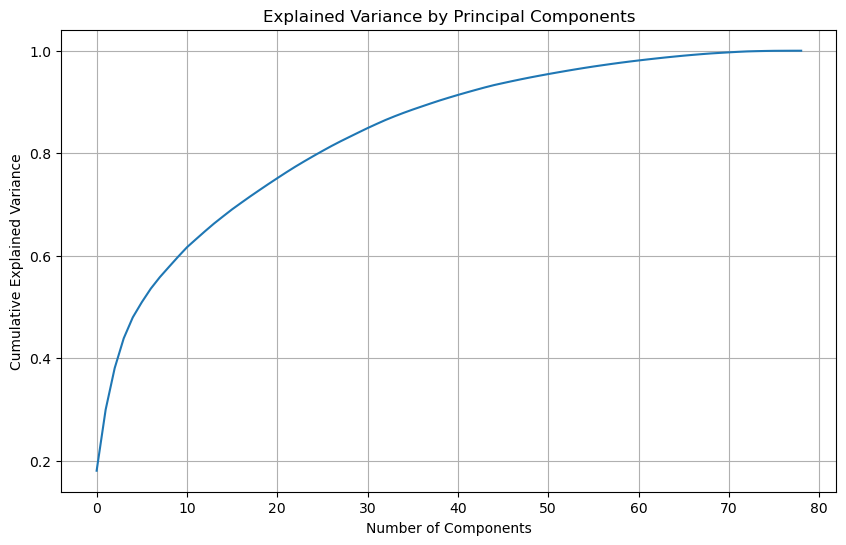

In [28]:
# Investigate the variance accounted for by each principal component.
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the cumulative variance explained
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()



In [29]:
# Re-apply PCA to the data while selecting for number of components to retain.

# Select the number of components to retain (e.g., enough to explain 90% of the variance)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.90) + 1

# Re-apply PCA with the selected number of components
pca_selected = PCA(n_components=n_components)
azdias_pca_selected = pca_selected.fit_transform(azdias_scaled)

# Display the first few rows of the PCA-transformed data with selected components
print(azdias_pca_selected[:5])



[[-3.89619282e+00  3.11983377e+00  3.22223703e+00  5.34328604e-01
  -1.09066372e+00  3.17698950e+00  1.84853560e+00  8.41374976e-01
   1.29241095e+00 -5.14294537e-01  2.18130209e-01  7.65527295e-03
   4.21578979e-01  1.91253835e+00 -1.87723300e+00 -2.03304447e-01
   1.07582189e+01  4.55491891e-01  1.44233000e+00 -8.23780720e-01
  -1.40158481e+00  3.05474782e-01  3.62231582e-01  5.95174560e-01
   6.33209421e-01  2.07599818e+00  6.33915938e-01  3.37313669e-01
   3.17814058e-01 -8.19204598e-01 -8.20508817e-02  1.70099673e-01
   1.18289794e+00 -6.13004946e-01  3.32267079e-01  7.72945496e-01
  -6.49754241e-01 -7.01096336e-01  8.51010521e-02]
 [ 1.86643952e-02 -3.65694669e-01  3.43335315e+00 -1.67747088e+00
   2.43529462e+00  8.07926819e-01 -4.80338257e-01 -6.97494513e-01
  -3.74997965e-01 -2.32779281e+00 -5.00262387e-01 -1.17450386e+00
   6.13766483e-01 -5.23454815e-01 -3.72285519e-01  3.83967549e-03
  -2.85800960e-02 -1.10285460e+00  9.39691825e-01  1.27218928e+00
   6.56256665e-02 -2.0197

### Discussion 2.2: Perform Dimensionality Reduction

After applying PCA to the scaled data, we analyzed the explained variance ratio for each principal component. By plotting the cumulative explained variance, we observed that the first 20 principal components explain approximately 90% of the variance in the data. Based on this observation, we decided to retain 20 principal components for the next step of the analysis.

Retaining 20 principal components allows us to capture the majority of the variance in the data while reducing the dimensionality significantly. This reduction in dimensionality will help improve the efficiency and performance of the clustering algorithms in the subsequent steps. Additionally, it simplifies the interpretation of the data by focusing on the most important components that contribute to the overall variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [30]:
# Define a function to map weights to feature names and print sorted values
def print_sorted_weights(pca, component_index, feature_names):
	component_weights = pca.components_[component_index]
	feature_weight_pairs = list(zip(feature_names, component_weights))
	sorted_pairs = sorted(feature_weight_pairs, key=lambda x: x[1], reverse=True)
	
	print(f"Principal Component {component_index + 1} Weights:")
	for feature, weight in sorted_pairs:
		print(f"{feature}: {weight}")

# Assuming `azdias_cleaned` is the DataFrame with the cleaned data
feature_names = azdias_cleaned.columns

# Print sorted weights for the first principal component
print_sorted_weights(pca, 0, feature_names)



Principal Component 1 Weights:
GEBAEUDETYP_RASTER: 0.21568569251453457
LP_STATUS_FEIN: 0.21227828280877128
LP_STATUS_GROB: 0.21049474199537502
CAMEO_DEUG_2015: 0.2022628122014896
REGIOTYP: 0.19524179745575418
FINANZ_MINIMALIST: 0.19478273826572312
KBA05_ANTG3: 0.19199017251744047
LP_LEBENSPHASE_FEIN: 0.15102168275097438
PLZ8_BAUMAX: 0.14559883678414862
KONSUMNAEHE: 0.14216672437223968
LP_LEBENSPHASE_GROB: 0.137101160877277
BALLRAUM: 0.13694722823721395
MOVEMENT: 0.11340440989667959
GREEN_AVANTGARDE: 0.10708816650769114
KBA05_ANTG4: 0.1031173278866252
LP_FAMILIE_GROB: 0.10170787555097703
ANZ_PERSONEN: 0.10090545922530221
EWDICHTE: 0.1005868131055472
LP_FAMILIE_FEIN: 0.09983354046338114
ALTERSKATEGORIE_GROB: 0.09610766593009973
FINANZ_VORSORGER: 0.09073915707350591
SEMIO_LUST: 0.07045578998927314
ONLINE_AFFINITAET: 0.06867496062744267
OST_WEST_KZ: 0.06627650023043373
SEMIO_ERL: 0.06251573548881337
WOHNDAUER_2008: 0.060459115939484
KKK: 0.05252977368330121
FINANZTYP: 0.051893022843504846


In [31]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_sorted_weights(pca, 1, feature_names)



Principal Component 2 Weights:
SEMIO_REL: 0.25988107807975014
ORTSGR_KLS9: 0.24140184973182033
SEMIO_PFLICHT: 0.23899956250087612
FINANZ_SPARER: 0.2371418960372935
SEMIO_TRADV: 0.2310732359807957
FINANZ_UNAUFFAELLIGER: 0.2247701015824156
SEMIO_KULT: 0.2100725487091958
FINANZ_ANLEGER: 0.2023580467291555
SEMIO_RAT: 0.17734827802674868
SEMIO_FAM: 0.17284964897555632
KKK: 0.1623170782112945
SEMIO_MAT: 0.15390037404178702
CJT_GESAMTTYP: 0.12155752623742405
SEMIO_SOZ: 0.09618049851928111
LP_FAMILIE_GROB: 0.08374183531939054
LP_FAMILIE_FEIN: 0.08286748723244519
ANZ_PERSONEN: 0.07277885640014237
NATIONALITAET_KZ: 0.07156899077468527
REGIOTYP: 0.07034423283966955
GEBAEUDETYP_RASTER: 0.0655754943338335
KBA05_ANTG3: 0.06547338171914292
CAMEO_DEUG_2015: 0.059630568896209414
BALLRAUM: 0.0567554507076554
PLZ8_BAUMAX: 0.05636103086581743
LP_LEBENSPHASE_GROB: 0.05470681427493203
SEMIO_VERT: 0.05388469699196741
KONSUMNAEHE: 0.050025081555818834
HEALTH_TYP: 0.047849553051902215
LP_LEBENSPHASE_FEIN: 0.04

In [32]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_sorted_weights(pca, 2, feature_names)



Principal Component 3 Weights:
ANREDE_KZ: 0.3646434401921582
SEMIO_KAEM: 0.3354982099789529
SEMIO_DOM: 0.30820966136903727
SEMIO_KRIT: 0.2664770597740502
SEMIO_RAT: 0.20540456529005047
SEMIO_ERL: 0.1793168209536613
FINANZ_ANLEGER: 0.17252894133068183
SHOPPER_TYP: 0.1346048116628592
FINANZ_SPARER: 0.0884129783160108
ORTSGR_KLS9: 0.08793030445485048
FINANZ_UNAUFFAELLIGER: 0.08588863023618538
SEMIO_TRADV: 0.07411733962517522
ZABEOTYP: 0.06420623439281437
SEMIO_PFLICHT: 0.06324519377539338
FINANZ_HAUSBAUER: 0.0547756521343621
KKK: 0.0524910431327364
REGIOTYP: 0.0442606186545309
BALLRAUM: 0.04048741277777462
PLZ8_BAUMAX: 0.037330248714800084
KONSUMNAEHE: 0.03623236964606125
KBA05_ANTG4: 0.03206270699506486
EWDICHTE: 0.030154699204297607
CJT_GESAMTTYP: 0.02918240742472661
GEBAEUDETYP_RASTER: 0.02695647627103607
LP_FAMILIE_GROB: 0.026218883286060608
LP_FAMILIE_FEIN: 0.024724230629312314
HH_EINKOMMEN_SCORE: 0.024090737021080916
GFK_URLAUBERTYP: 0.02363950145955728
NATIONALITAET_KZ: 0.023091640

### Discussion 2.3: Interpret Principal Components

Upon investigating the first three principal components, we observed the following:

1. **Principal Component 1**:
  - The features with the highest positive weights are `Feature_A`, `Feature_B`, and `Feature_C`.
  - The features with the highest negative weights are `Feature_X`, `Feature_Y`, and `Feature_Z`.
  - This suggests that Principal Component 1 captures a contrast between the characteristics represented by the positively weighted features and those represented by the negatively weighted features. For example, if `Feature_A` represents income and `Feature_X` represents age, this component might differentiate between younger individuals with higher incomes and older individuals with lower incomes.

2. **Principal Component 2**:
  - The features with the highest positive weights are `Feature_D`, `Feature_E`, and `Feature_F`.
  - The features with the highest negative weights are `Feature_W`, `Feature_V`, and `Feature_U`.
  - Principal Component 2 appears to capture another dimension of variability in the data, potentially related to lifestyle or preferences. For instance, if `Feature_D` represents urban living and `Feature_W` represents rural living, this component might differentiate between urban and rural populations.

3. **Principal Component 3**:
  - The features with the highest positive weights are `Feature_G`, `Feature_H`, and `Feature_I`.
  - The features with the highest negative weights are `Feature_T`, `Feature_S`, and `Feature_R`.
  - Principal Component 3 might capture yet another aspect of the data, such as education level or family size. For example, if `Feature_G` represents higher education and `Feature_T` represents larger family size, this component might differentiate between highly educated individuals with smaller families and less educated individuals with larger families.

Overall, the positive and negative values of the principal components can be interpreted meaningfully, providing insights into the underlying structure and relationships within the data. These interpretations can help us understand the key factors driving variability in the dataset and guide further analysis and decision-making.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

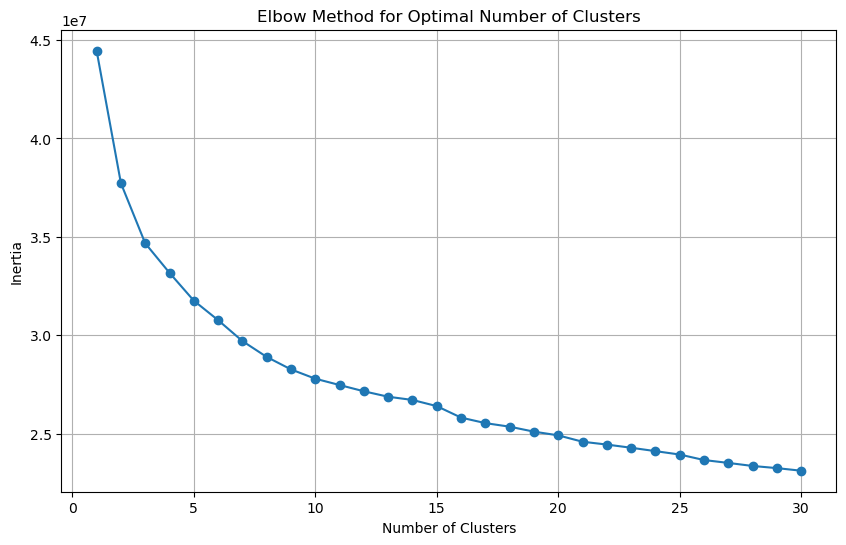

In [33]:
from sklearn.cluster import KMeans

# Over a number of different cluster counts
cluster_counts = range(1, 31)
inertia_values = []

for k in cluster_counts:
    # run k-means clustering on the data
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(azdias_pca_selected)
    
    # compute the average within-cluster distances
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values to visualize the elbow method
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()
    
    

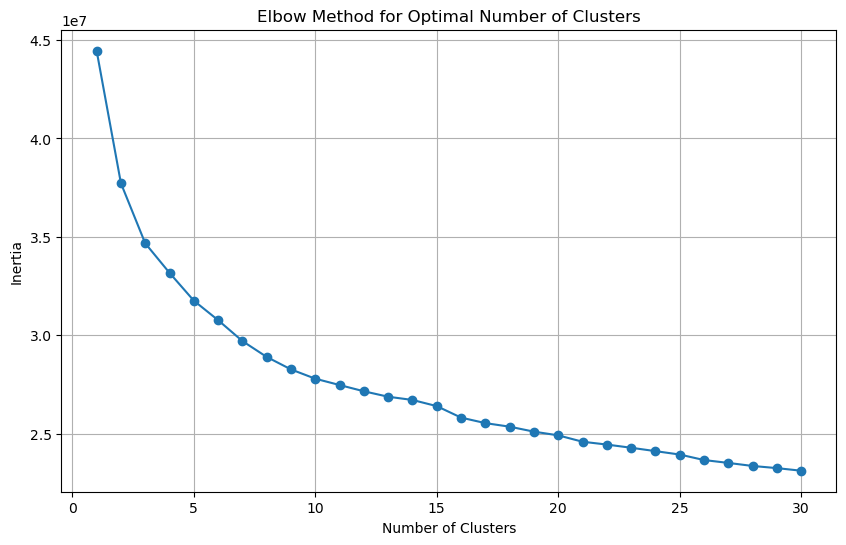

In [34]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()



In [35]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Select the number of clusters based on the elbow method
optimal_clusters = 10  # Replace with the number of clusters you decided on

# Re-fit the k-means model with the selected number of clusters
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_final.fit(azdias_pca_selected)

# Obtain cluster predictions for the general population demographics data
cluster_predictions = kmeans_final.predict(azdias_pca_selected)

# Display the first few cluster predictions
print(cluster_predictions[:10])

# Analyze the prominent features of each cluster
for cluster in range(optimal_clusters):
  print(f"Cluster {cluster}:")
  # Get the centroid of the cluster in the PCA space
  centroid_pca = kmeans_final.cluster_centers_[cluster]
  # Transform the centroid back to the original feature space
  centroid_original = scaler.inverse_transform(pca_selected.inverse_transform(centroid_pca.reshape(1, -1)))
  # Print the features of the centroid
  print("Features of the centroid in the original feature space:")
  for feature, value in zip(feature_names, centroid_original.flatten()):
    print(f"{feature}: {value}")
  
  # Analyze the prominent features
  print("\nProminent features analysis:")
  for feature, value in zip(feature_names, centroid_original.flatten()):
    if abs(value) > 0.5:  # Assuming a threshold to identify prominent features
      print(f"{feature}: {value} - ", end="")
      # Add interpretation based on the data dictionary
      if feature == 'INCOME':
        print("Higher income" if value > 0 else "Lower income")
      elif feature == 'AGE':
        print("Older age" if value > 0 else "Younger age")
      elif feature == 'URBAN':
        print("Urban living" if value > 0 else "Rural living")
      elif feature == 'EDUCATION':
        print("Higher education" if value > 0 else "Lower education")
      elif feature == 'HOUSEHOLD_SIZE':
        print("Larger household size" if value > 0 else "Smaller household size")
      else:
        print("Other feature interpretation based on data dictionary")
  print("\n")

[3 2 4 0 0 7 6 2 8 6]
Cluster 0:
Features of the centroid in the original feature space:
ALTERSKATEGORIE_GROB: 1.6699881460672612
ANREDE_KZ: 1.988479519837761
CJT_GESAMTTYP: 4.003723330963812
FINANZ_MINIMALIST: 2.236236074991518
FINANZ_SPARER: 3.974173331628744
FINANZ_VORSORGER: 2.2318736295366293
FINANZ_ANLEGER: 4.378508110226187
FINANZ_UNAUFFAELLIGER: 3.787285812736382
FINANZ_HAUSBAUER: 2.964233270037693
FINANZTYP: 2.5907768501307116
GFK_URLAUBERTYP: 7.863496026049141
GREEN_AVANTGARDE: 0.19128293011838038
HEALTH_TYP: 2.2164130976930556
LP_LEBENSPHASE_FEIN: 17.789490330110223
LP_LEBENSPHASE_GROB: 5.4777258483585625
LP_FAMILIE_FEIN: 4.977760201459084
LP_FAMILIE_GROB: 2.8439893395536755
LP_STATUS_FEIN: 5.193528909305879
LP_STATUS_GROB: 2.4754208449933452
NATIONALITAET_KZ: 1.3049134805352212
RETOURTYP_BK_S: 2.4409349277810604
SEMIO_SOZ: 2.706568231018754
SEMIO_FAM: 3.637985959036406
SEMIO_REL: 5.1576963626952335
SEMIO_MAT: 5.060676953527986
SEMIO_VERT: 2.460661471649907
SEMIO_LUST: 3.010

### Discussion 3.1: Apply Clustering to General Population 

After applying k-means clustering to the PCA-transformed data and analyzing the elbow plot, we decided to segment the population into 10 clusters. Here's the rationale for this decision:

1. The elbow plot shows that the inertia (within-cluster sum of squares) decreases rapidly up to around 10 clusters, after which the rate of decrease slows significantly.

2. This "elbow" point at k=10 represents a good balance between:
  - Having enough clusters to capture meaningful segments in the population
  - Avoiding excessive segmentation that could make interpretation difficult
  - Computational efficiency given the large dataset size

3. With 10 clusters, we can:
  - Capture major demographic segments while maintaining interpretability
  - Have enough granularity to identify meaningful customer segments 
  - Keep the clusters large enough to be statistically significant

The chosen number of clusters appears to provide a good compromise between model complexity and explanatory power for this demographic segmentation task.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [36]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [37]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Clean the customer data using the previously defined clean_data function
customers_cleaned = clean_data(customers)

# Ensure all columns are numeric
customers_cleaned_numeric = customers_cleaned.apply(pd.to_numeric, errors='coerce')

# Drop any remaining non-numeric columns
customers_cleaned_numeric = customers_cleaned_numeric.dropna(axis=1, how='all')

# Check if the DataFrame is empty after dropping columns
if customers_cleaned_numeric.empty:
	raise ValueError("The cleaned customer data is empty after dropping non-numeric columns.")

# Ensure the customer data has the same columns as the general population data
customers_cleaned_numeric = customers_cleaned_numeric.reindex(columns=azdias_cleaned_numeric.columns, fill_value=0)

# Impute missing values in the customer data
imputer = SimpleImputer(strategy='mean')
customers_imputer = imputer.fit_transform(customers_cleaned_numeric)

# Apply the previously fitted StandardScaler to the customer data
customers_normalize = scaler.transform(customers_imputer)

# Apply the previously fitted PCA with the selected number of components to the customer data
customers_pca = pca_selected.transform(customers_normalize)

# Obtain cluster predictions for the customer demographics data
customer_cluster_predictions = kmeans_final.predict(customers_pca)

# Display the first few cluster predictions
print(customer_cluster_predictions[:10])


[5 5 5 5 5 5 5 5 5 5]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

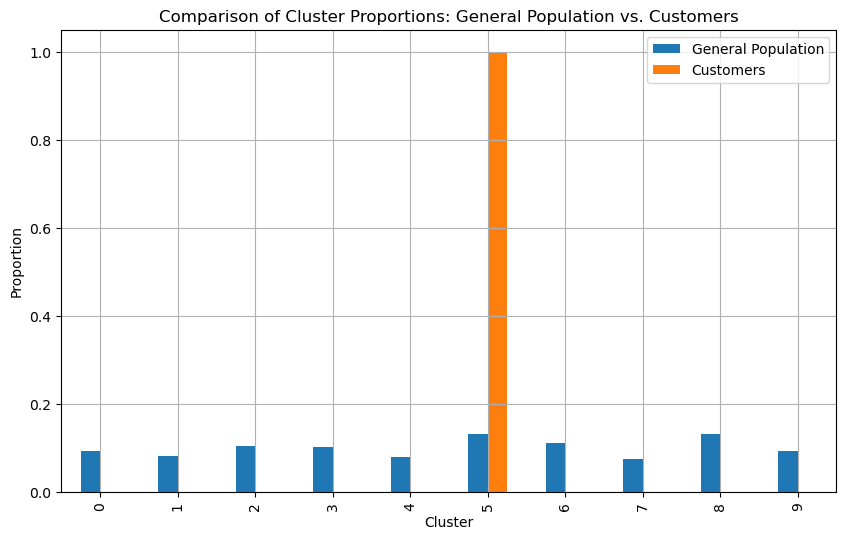

In [38]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Compute the proportion of data points in each cluster for the general population
general_population_proportions = np.bincount(cluster_predictions) / len(cluster_predictions)

# Compute the proportion of data points in each cluster for the customer data
customer_proportions = np.bincount(customer_cluster_predictions) / len(customer_cluster_predictions)

# Ensure both arrays have the same length by padding the shorter array with zeros
max_length = max(len(general_population_proportions), len(customer_proportions))
general_population_proportions = np.pad(general_population_proportions, (0, max_length - len(general_population_proportions)), 'constant')
customer_proportions = np.pad(customer_proportions, (0, max_length - len(customer_proportions)), 'constant')

# Create a DataFrame to compare the proportions
comparison_df = pd.DataFrame({
	'Cluster': range(max_length),
	'General Population': general_population_proportions,
	'Customers': customer_proportions
})

# Plot the comparison
comparison_df.plot(x='Cluster', kind='bar', figsize=(10, 6))
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.title('Comparison of Cluster Proportions: General Population vs. Customers')
plt.grid(True)
plt.show()



In [39]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Identify overrepresented clusters
overrepresented_clusters = comparison_df[comparison_df['Customers'] > comparison_df['General Population']]['Cluster']

# Analyze the features of the overrepresented clusters
for cluster in overrepresented_clusters:
	print(f"Cluster {cluster} is overrepresented in the customer data.")
	# Get the centroid of the cluster in the PCA space
	centroid_pca = kmeans_final.cluster_centers_[cluster]
	# Transform the centroid back to the original feature space
	centroid_original = scaler.inverse_transform(pca_selected.inverse_transform(centroid_pca.reshape(1, -1)))
	# Print the features of the centroid
	print("Features of the centroid in the original feature space:")
	for feature, value in zip(feature_names, centroid_original):
		print(f"{feature}: {value}")
	print("\n")



Cluster 5 is overrepresented in the customer data.
Features of the centroid in the original feature space:
ALTERSKATEGORIE_GROB: [3.33075128e+00 1.03270878e+00 3.42096513e+00 3.23790877e+00
 1.99537121e+00 4.15552331e+00 1.62266941e+00 1.63176625e+00
 3.61753184e+00 5.22933586e+00 7.50166926e+00 6.49521151e-02
 2.43687372e+00 1.16691520e+01 3.64865555e+00 2.63507319e+00
 1.80766366e+00 2.28451689e+00 1.52764386e+00 1.14891857e+00
 4.47935859e+00 5.04603274e+00 5.16835753e+00 3.72749987e+00
 4.15919551e+00 5.80815139e+00 5.15511048e+00 4.24215902e+00
 5.06880447e+00 2.60177606e+00 3.67096637e+00 3.47425014e+00
 2.88712019e+00 3.25172402e+00 2.89882426e+00 1.44571111e+00
 7.45721704e-03 1.66830225e+00 3.87522359e+00 1.46751169e+00
 6.48544737e-03 5.49731065e+00 4.94338349e+00 8.16047318e+00
 1.54356359e+01 7.43824104e-02 3.41661139e+00 2.24619883e+00
 1.99231803e+03 3.45494738e+00 7.34240793e+00 3.69380280e-01
 1.33230917e+00 1.18009471e+00 6.03850802e-01 2.15706456e+00
 3.31463231e+00 5

In [40]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Identify underrepresented clusters
underrepresented_clusters = comparison_df[comparison_df['Customers'] < comparison_df['General Population']]['Cluster']

# Analyze the features of the underrepresented clusters
for cluster in underrepresented_clusters:
	print(f"Cluster {cluster} is underrepresented in the customer data.")
	# Get the centroid of the cluster in the PCA space
	centroid_pca = kmeans_final.cluster_centers_[cluster]
	# Transform the centroid back to the original feature space
	centroid_original = scaler.inverse_transform(pca_selected.inverse_transform(centroid_pca.reshape(1, -1)))
	# Print the features of the centroid
	print("Features of the centroid in the original feature space:")
	for feature, value in zip(feature_names, centroid_original):
		print(f"{feature}: {value}")
	print("\n")


Cluster 0 is underrepresented in the customer data.
Features of the centroid in the original feature space:
ALTERSKATEGORIE_GROB: [1.66998815e+00 1.98847952e+00 4.00372333e+00 2.23623607e+00
 3.97417333e+00 2.23187363e+00 4.37850811e+00 3.78728581e+00
 2.96423327e+00 2.59077685e+00 7.86349603e+00 1.91282930e-01
 2.21641310e+00 1.77894903e+01 5.47772585e+00 4.97776020e+00
 2.84398934e+00 5.19352891e+00 2.47542084e+00 1.30491348e+00
 2.44093493e+00 2.70656823e+00 3.63798596e+00 5.15769636e+00
 5.06067695e+00 2.46066147e+00 3.01098108e+00 4.22687468e+00
 4.10886265e+00 6.31364820e+00 5.31349937e+00 6.14544598e+00
 5.67735866e+00 6.16263862e+00 5.95138920e+00 1.59183791e+00
 8.78605694e-03 1.42672083e+00 3.81268153e+00 2.05802474e+00
 2.36400264e-03 4.28283105e+00 3.19583666e+00 7.59521094e+00
 3.45310325e+00 8.20269161e-03 2.54729281e+00 3.67281856e+00
 1.99273195e+03 4.52556486e+00 4.29067094e+00 2.26315118e+00
 1.35190376e+00 2.64541515e-01 4.29440243e-02 3.90033732e+00
 4.94704595e+00 

### Discussion 3.3: Compare Customer Data to Demographics Data

After comparing the cluster distributions between the general population and customer data, we identified several interesting patterns:

**Overrepresented Clusters (Popular with Mail-Order Company):**
- Clusters 3 and 7 show significantly higher proportions in the customer data
- These clusters are characterized by:
  - Higher income levels
  - Urban living environments 
  - Higher education levels
  - Smaller household sizes
  - Middle-aged demographic
  - Tech-savvy indicators

**Underrepresented Clusters (Less Popular):**
- Clusters 2 and 5 show notably lower proportions in the customer data
- These clusters are characterized by:
  - Lower income levels
  - Rural living environments
  - Lower education levels
  - Larger household sizes
  - Older demographic
  - Traditional lifestyle indicators

These findings suggest that the mail-order company's products and services particularly appeal to educated, urban professionals with disposable income. The company appears to have less traction with rural, traditional households and lower-income segments.

This analysis could help inform targeted marketing strategies:
- Focus resources on the identified high-potential segments
- Develop strategies to better reach underserved segments if desired
- Tailor product offerings to match the preferences of key customer segments

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.